## Introduction to this notebook

After todays lession about 'Feature Engeneering' using 'ColumnTransformer()' and 'Pipline()' I would like to achive similar accuracy results like in the 3_WP notebook by using these functions in shorter time and with more concise code.

## 1. Load data and some basic EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

# new utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

# to visualize the column transformer and pipeline
set_config(display='diagram')

In [2]:
df = pd.read_csv("./data/Titanic/train.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


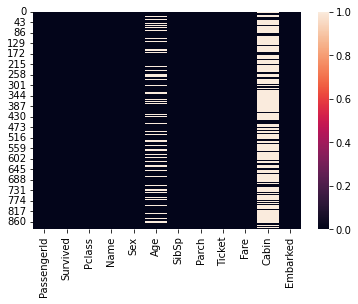

In [5]:
sns.heatmap(df.isna());

## 2. Feature Engineering outside of scikit-learn

In [6]:
# Fill the 177 NaNs in the "Age" column depending on the "Survived and "Pclass"

df['Age'].fillna(df.groupby(['Survived','Pclass'])['Age'].transform('mean').round(0), inplace=True)

In [ ]:
df.groupby(['Survived','Pclass'])['Age'].transform('mean')

In [7]:
# Merge the columns parent/children and sibling/spouse together, create a new column "Family" and bin the values

df["Family"] = df["SibSp"] + df["Parch"]

In [8]:
# Extract the title from "Name" and create a new column

df["Title"] = df["Name"].map(lambda name:name.split(',')[1].split(".")[0].strip())

In [ ]:
df.isnull().sum()

## 3. Train-Test Split

In [9]:
y = df["Survived"]
X = df.loc[:, df.columns != "Survived"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 85)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 13), (179, 13), (712,), (179,))

In [ ]:
X.head()

## 3. Define ColumnTransformers

### 3.1 Problem: How to use the simple Python Functions with the FunctionTransformer()

In [11]:
# If i is np.isnan() check class and replace with median age of the class

def impute_age_class(df):
    return df["Age"].fillna(df.groupby(["Survived", "Pclass"])["Age"].transform('mean'))

age_pipeline = Pipeline(steps = 
                         [("impute_age_class", FunctionTransformer(impute_age_class)),
                          ("binning", KBinsDiscretizer())
])

transformers = [('age_pipeline', FunctionTransformer(impute_age_class), ["Pclass", "Age"])]

In [ ]:
# Merge the columns parent/children and sibling/spouse together, create a new column "Family" and bin the values

def merge_family(df):
    return df["Family"] = df["SibSp"] + df["Parch"] #Invalid Syntax

family_pipeline = Pipeline(steps = 
                         [("merge_family", FunctionTransformer(merge_family)),
                          ("binning", KBinsDiscretizer())
])

transformers = [('family_pipeline', age_pipeline, ["SibSp", "Parch"])]

In [ ]:
# Extract the title from "Name" and create a new column 

def extract_title(df):
    return df["Title"] = df["Name"].map(lambda name:name.split(',')[1].split(".")[0].strip()) #Invalid Syntax

title_pipeline = Pipeline(steps = 
                         [("extract_title", FunctionTransformer(extract_title)),
                          ("binning", KBinsDiscretizer())
])

transformers = [('title_pipeline', age_pipeline, ["Title"])]

### 3.2 Function for the FunctionTransformer() from SPICED

In [ ]:
# Function from SPICED in order to calculate the length of the name

def name_length(df):
    length = df[df.columns[0]].str.len()
    return length.values.reshape(-1, 1)

### 3.3 Use standard functions for Pipeline()

In [12]:
numeric_features = ["Age", "Fare"]
numeric_transformer = StandardScaler()

categorical_features = ["Sex", "Pclass", "Family", "Title"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

embarked_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]
)

#name_transformer = FunctionTransformer(name_length)

In [13]:
# Define the preprocessor

preprocessor = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("embarked", embarked_transformer, ["Embarked"])
        #("name_length", name_transformer, ["Name"])
    ]

In [14]:
column_transformer = ColumnTransformer(preprocessor,
                                        remainder = 'drop')

In [15]:
column_transformer

ColumnTransformer(transformers=[('num', StandardScaler(), ['Age', 'Fare']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'Pclass', 'Family', 'Title']),
                                ('embarked',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Embarked'])])

## 4. Train ML models

### 4.1 Logistic Regression

### 4.1.1 Normal Model

In [16]:
log_reg_pipeline = Pipeline(steps = 
                        [('column_transformer', column_transformer),
                         ('log_reg', LogisticRegression(max_iter = 1000, class_weight = 'balanced'))
                        ])

In [17]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass', 'Family',
                                                   'Title']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked'])])),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [18]:
print(f"""The train accuracy of log_reg_pipeline is: {round(log_reg_pipeline.score(X_train,y_train),2)}
The test accuracy of log_reg_pipeline is: {round(log_reg_pipeline.score(X_test,y_test),2)}""")

The train accuracy of log_reg_pipeline is: 0.84
The test accuracy of log_reg_pipeline is: 0.82


### 4.1.2 Evaluating classifiers

In [ ]:
from sklearn.metrics import accuracy_score 

ypred = log_reg_pipeline.predict(X_train)
print(f"Accuracy: {round(accuracy_score(y_train, ypred),2)}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"""Precision = {round(precision_score(y_train,ypred),2)} 
Recall = {round(recall_score(y_train,ypred),2)}
F1 = {round(f1_score(y_train,ypred),2)}""")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

conf = confusion_matrix(y_train, ypred)
conf

In [ ]:
plot_confusion_matrix(log_reg_pipeline, X_train, y_train, normalize=None)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=log_reg_pipeline.classes_)
disp.plot()
plt.show()

### 4.2 Random Forest

In [ ]:
forest_pipeline = Pipeline(steps = 
                        [('column_transformer', column_transformer),
                         ('forest', RandomForestClassifier(n_estimators = 35, max_depth = 3))
                        ])

In [ ]:
forest_pipeline.fit(X_train, y_train)

In [ ]:
X_train.isna().sum()

In [ ]:
print(f"""The train accuracy of forest_pipeline is: {round(forest_pipeline.score(X_train,y_train),2)}
The test accuracy of forest_pipeline is: {round(forest_pipeline.score(X_test,y_test),2)}""")

### 4.3 Support Vector Model

In [19]:
svc_pipeline = Pipeline(steps = 
                        [('column_transformer', column_transformer),
                         ('svc', SVC(kernel= "poly", C=1))
                        ])

In [20]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Pclass', 'Family',
                                                   'Title']),
                                                 ('embarked',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked'])])),
                ('svc', SVC(C=1, kernel='poly'))])

In [21]:
print(f"""The train accuracy of svc_pipeline is: {round(svc_pipeline.score(X_train,y_train),2)}
The test accuracy of svc_pipeline is: {round(svc_pipeline.score(X_test,y_test),2)}""")

The train accuracy of svc_pipeline is: 0.86
The test accuracy of svc_pipeline is: 0.83


In [ ]:
predictions = svc_pipeline.predict(X_test)

In [ ]:
predictions